# 作業 3-1

- Name: **林啟允**
- Student ID: **C44056223**
- Final Edit Date: **2020/5/28**

## Github

- [Link](https://github.com/Chi-Yun-Lin/FDA_HW3_1)

## 環境

|環境|名稱|版本|
|-|-|-|
|作業系統|Ubuntu|16.04.6 LTS|
|程式執行環境|jupyter notebook|1.0.0|
|python 版本|python3|3.6.9|
|安裝環境|pip|20.0.2|

## 安裝

```sh
pip install -r requirements.txt
```

## 計算資源

|計算資源|答案|
|-|-|
|使用 CPU 核心數|1|
|記憶體需求|$\leq 1$GB|
|有無使用 GPU|無|
|GPU 版本|無|
|GPU 記憶體需求|$\leq 1$GB|

## 參考連結

- 有無參考他人之實驗結果：無
- 參考連結：
    1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html (LogisticRegression 相關參數說明文件)
    2. https://realpython.com/logistic-regression-python/ (Logistic Regression in Python)
    3. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html (MLPClassifier 相關參數說明文件)
    4. https://www.jianshu.com/p/71fde5d90136 (sklearn 神經網路 MLPClassifier 簡單應用與參數說明)
    5. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier (KNeighborsClassifier 相關參數說明文件)

In [1]:
# 請勿更動此區塊程式碼

import time
import numpy as np
import pandas as pd

EXECUTION_START_TIME = time.time() # 計算執行時間

df = pd.read_csv('train.csv')      # 讀取資料，請勿更改路徑

## 資料分析與前處理

### 預覽訓練資料

利用下面三種方式對訓練資料做一個初步認識，並得到以下資訊:
- 2264 筆股票資料 (Row)
- 6 種資料類型 (Column)
- 不含缺失值
- dtypes 為 object 有 1 個
- 驗證測試的答案需要自行生成

In [2]:
# 預覽訓練資料

df.head(10)                                     # 預覽訓練資料前 10 筆

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952
5,09-Jan-2009,909.91,890.35,911.93,888.31,4716499968
6,12-Jan-2009,890.40,870.26,890.40,864.32,4725049856
7,13-Jan-2009,869.79,871.79,877.02,862.02,5017469952
8,14-Jan-2009,867.28,842.62,867.28,836.93,5407880192
9,15-Jan-2009,841.99,843.74,851.59,817.04,7807350272


In [3]:
# 預覽訓練資料

df.info()                                      # 輸出訓練資料型態與大小

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         2264 non-null   object 
 1   Open Price   2264 non-null   float64
 2   Close Price  2264 non-null   float64
 3   High Price   2264 non-null   float64
 4   Low Price    2264 non-null   float64
 5   Volume       2264 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 106.2+ KB


In [4]:
# 預覽訓練資料

df.describe()                                  # 輸出訓練資料統計資訊

,Open Price,Close Price,High Price,Low Price,Volume
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03
mean,1656.142686,1656.767562,1664.427054,1647.425128,2.948755e+09
std,485.292193,485.226120,484.808706,485.576116,1.351675e+09
min,679.280000,676.530000,695.270000,666.790000,5.181584e+08
25%,1238.602500,1239.337500,1246.695000,1227.587500,2.048980e+09
50%,1649.135000,1650.405000,1656.145000,1639.600000,2.506637e+09
75%,2070.300000,2071.190000,2079.507500,2058.757500,3.373334e+09
max,2692.710000,2690.160000,2694.970000,2685.920000,9.120100e+09


### 資料視覺化

- 將資料前 10 筆以折線圖呈現
- 觀察開盤價格 (Open Price) 和收盤價格 (Close Price) 兩個特徵值，發現兩者被 High Price 和 Low Price 給 bound 在中間，且**今日開盤價格**和**昨日收盤價格**不會相差太遠，因此將開盤價格和收盤價格作為特徵值餵給模型應該可以找出關聯性

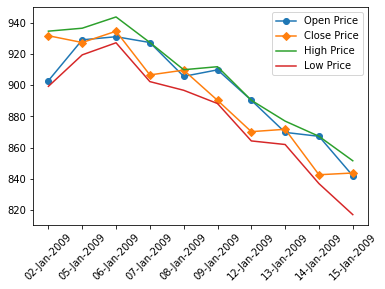

In [5]:
# 資料視覺化

import matplotlib.pyplot as plt               # 匯入資料視覺化模組

x = df['Date'][:10]                           # 準備 x 軸資料
y_open = df['Open Price'][:10]                # 準備 y 軸資料
y_close = df['Close Price'][:10]              # "
y_high = df['High Price'][:10]                # "
y_low = df['Low Price'][:10]                  # "

plt.plot(x,                                   # 畫出 Open Price 折線圖
         y_open,
         marker='o',
         label='Open Price')
plt.plot(x,                                   # 畫出 Close Price 折線圖
         y_close,
         marker='D',
         label='Close Price')
plt.plot(x,                                   # 畫出 High Price 折線圖
         y_high,
         label='High Price')
plt.plot(x,                                   # 畫出 Low Price 折線圖
         y_low,
         label='Low Price')
plt.xticks(x, rotation=45)                    # 將 x label 旋轉 45 度
plt.legend()                                  # 顯示添加的標示
plt.show()                                    # 繪製圖表

### 生成驗證測試的答案

- 目標
    - 以**每日收盤價相對於前一天的收盤價之漲跌**作為驗證測試的答案
- 新增 RF pred 作為輸出結果

### 加入特徵值

- 以開盤價格 (Open Price) 及收盤價格 (Close Price) 作為特徵值，測試訓練結果

In [6]:
# 生成驗證測試的答案
# 加入特徵值


df['RF pred'] = 0                                              # 新增 Rising-Falling Prediction 的欄位並初始化為 0

# 記錄與前一天的收盤價相比是漲 (Rising) 還跌 (Falling)
# 1:漲, 0:跌
for x in range(1,len(df)):
    if df['Close Price'][x] > df['Close Price'][x-1]:          # 將前後兩天的 Close Price 做比較
        df['RF pred'][x] = 1
    else:
        df['RF pred'][x] = 0


train_x = df[['Open Price', 'Close Price']]                    # 取出訓練資料需要分析的資料欄位
train_y = df['RF pred']                                        # 取出訓練資料的答案

# 檢視訓練資料
train_x.info()
train_x.head(10)

/mnt/d/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/mnt/d/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open Price   2264 non-null   float64
 1   Close Price  2264 non-null   float64
dtypes: float64(2)
memory usage: 35.5 KB


,Open Price,Close Price
0,902.99,931.80
1,929.17,927.45
2,931.17,934.70
3,927.45,906.65
4,905.73,909.73
5,909.91,890.35
6,890.40,870.26
7,869.79,871.79
8,867.28,842.62
9,841.99,843.74


## 模型訓練

使用 **5-fold cross validation** 對訓練資料先進行測試及驗證:
1. Logistic Regression
2. NN - Multilayer Perceptron Classifier
3. K Nearest Neighbor Classifier

使用**全部訓練資料**進行訓練:
1. Logistic Regression
2. NN - Multilayer Perceptron Classifier
3. K Nearest Neighbor Classifier

### 模型訓練 (Logistic Regression)

觀察訓練結果，可發現訓練準確度和驗證準確度的誤差值約為 0.2%，且準確度大約有 93%

In [7]:
# 模型訓練 LR

from sklearn.model_selection import KFold             # 匯入 K 次交叉驗證工具
from sklearn.linear_model import LogisticRegression   # 匯入邏輯迴歸模型
from sklearn.metrics import accuracy_score            # 匯入準確度計算工具

kf = KFold(n_splits=5,                                # 設定 K 值
           random_state=1012,
           shuffle=True)
kf.get_n_splits(train_x)                              # 給予資料範圍

train_acc_list = []                                   # 儲存每次訓練模型的準確度
valid_acc_list = []                                   # 儲存每次驗證模型的準確度

for train_index, valid_index in kf.split(train_x):    # 每個迴圈都會產生不同部份的資料
    train_x_split = train_x.iloc[train_index]         # 產生訓練資料
    train_y_split = train_y.iloc[train_index]         # 產生訓練資料標籤
    valid_x_split = train_x.iloc[valid_index]         # 產生驗證資料
    valid_y_split = train_y.iloc[valid_index]         # 產生驗證資料標籤
    
    model_LR = LogisticRegression(                    # 創造邏輯迴歸模型
        solver='liblinear',
        random_state=1012)
    model_LR.fit(train_x_split, train_y_split)        # 訓練邏輯迴歸模型
    
    train_pred_y = model_LR.predict(train_x_split)    # 確認模型是否訓練成功
    train_acc = accuracy_score(train_y_split,         # 計算訓練資料準確度
                               train_pred_y)
    valid_pred_y = model_LR.predict(valid_x_split)    # 驗證模型是否訓練成功
    valid_acc = accuracy_score(valid_y_split,         # 計算驗證資料準確度
                               valid_pred_y)
    
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

print((
    'average train accuracy: {}\n' +
    '    min train accuracy: {}\n' +
    '    max train accuracy: {}\n' +
    'average valid accuracy: {}\n' +
    '    min valid accuracy: {}\n' +
    '    max valid accuracy: {}').format(
    np.mean(train_acc_list),                          # 輸出平均訓練準確度
    np.min(train_acc_list),                           # 輸出最低訓練準確度
    np.max(train_acc_list),                           # 輸出最高訓練準確度
    np.mean(valid_acc_list),                          # 輸出平均驗證準確度
    np.min(valid_acc_list),                           # 輸出最低驗證準確度
    np.max(valid_acc_list)                            # 輸出最高驗證準確度
))

average train accuracy: 0.9382728554833536
    min train accuracy: 0.9331860850358917
    max train accuracy: 0.9403644395361679
average valid accuracy: 0.935949129695833
    min valid accuracy: 0.9247787610619469
    max valid accuracy: 0.9580573951434879


### 模型訓練 (NN - Multilayer Perceptron Classifier)

觀察訓練結果發現，訓練準確度約在 50%±10%，明顯為 underfitting

In [8]:
# 模型訓練 NN

from sklearn.model_selection import KFold             # 匯入 K 次交叉驗證工具
from sklearn.neural_network import MLPClassifier      # 匯入多層感知分類器模型
from sklearn.metrics import accuracy_score            # 匯入準確度計算工具

kf = KFold(n_splits=5,                                # 設定 K 值
           random_state=1012,
           shuffle=True)
kf.get_n_splits(train_x)                              # 給予資料範圍

train_acc_list = []                                   # 儲存每次訓練模型的準確度
valid_acc_list = []                                   # 儲存每次驗證模型的準確度

for train_index, valid_index in kf.split(train_x):    # 每個迴圈都會產生不同部份的資料
    train_x_split = train_x.iloc[train_index]         # 產生訓練資料
    train_y_split = train_y.iloc[train_index]         # 產生訓練資料標籤
    valid_x_split = train_x.iloc[valid_index]         # 產生驗證資料
    valid_y_split = train_y.iloc[valid_index]         # 產生驗證資料標籤
    
    model_MLP = MLPClassifier(                        # 創造多層感知分類器模型
        alpha = 1e-5,
        hidden_layer_sizes=(5, 3),
        random_state=1012,
        early_stopping=True)
    model_MLP.fit(train_x_split, train_y_split)       # 訓練多層感知分類器模型
    
    train_pred_y = model_MLP.predict(train_x_split)   # 確認模型是否訓練成功
    train_acc = accuracy_score(train_y_split,         # 計算訓練資料準確度
                               train_pred_y)
    valid_pred_y = model_MLP.predict(valid_x_split)   # 驗證模型是否訓練成功
    valid_acc = accuracy_score(valid_y_split,         # 計算驗證資料準確度
                               valid_pred_y)
    
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

print((
    'average train accuracy: {}\n' +
    '    min train accuracy: {}\n' +
    '    max train accuracy: {}\n' +
    'average valid accuracy: {}\n' +
    '    min valid accuracy: {}\n' +
    '    max valid accuracy: {}').format(
    np.mean(train_acc_list),                          # 輸出平均訓練準確度
    np.min(train_acc_list),                           # 輸出最低訓練準確度
    np.max(train_acc_list),                           # 輸出最高訓練準確度
    np.mean(valid_acc_list),                          # 輸出平均驗證準確度
    np.min(valid_acc_list),                           # 輸出最低驗證準確度
    np.max(valid_acc_list)                            # 輸出最高驗證準確度
))

average train accuracy: 0.5459362882946136
    min train accuracy: 0.5400331308669244
    max train accuracy: 0.5516289342904472
average valid accuracy: 0.5459346734650022
    min valid accuracy: 0.5231788079470199
    max valid accuracy: 0.5695364238410596


### 模型訓練 (K Nearest Neighbor Classifier)

觀察訓練結果發現，當 KNeighborsClassifier 的參數 n_neighbors 小於 3 時，會有 overfitting 的問題產生，建議使用 default 的 5

In [9]:
# 模型訓練 KNN

from sklearn.model_selection import KFold             # 匯入 K 次交叉驗證工具
from sklearn.neighbors import KNeighborsClassifier    # 匯入 K 個最近鄰分類器模型
from sklearn.metrics import accuracy_score            # 匯入準確度計算工具

kf = KFold(n_splits=5,                                # 設定 K 值
           random_state=1012,
           shuffle=True)
kf.get_n_splits(train_x)                              # 給予資料範圍

train_acc_list = []                                   # 儲存每次訓練模型的準確度
valid_acc_list = []                                   # 儲存每次驗證模型的準確度

for train_index, valid_index in kf.split(train_x):    # 每個迴圈都會產生不同部份的資料
    train_x_split = train_x.iloc[train_index]         # 產生訓練資料
    train_y_split = train_y.iloc[train_index]         # 產生訓練資料標籤
    valid_x_split = train_x.iloc[valid_index]         # 產生驗證資料
    valid_y_split = train_y.iloc[valid_index]         # 產生驗證資料標籤
    
    model_KNC = KNeighborsClassifier(                 # 創造 K 個最近鄰分類器模型
        n_neighbors=5)
    model_KNC.fit(train_x_split, train_y_split)       # 訓練 K 個最近鄰分類器模型
    
    train_pred_y = model_KNC.predict(train_x_split)   # 確認模型是否訓練成功
    train_acc = accuracy_score(train_y_split,         # 計算訓練資料準確度
                               train_pred_y)
    valid_pred_y = model_KNC.predict(valid_x_split)   # 驗證模型是否訓練成功
    valid_acc = accuracy_score(valid_y_split,         # 計算驗證資料準確度
                               valid_pred_y)
    
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

print((
    'average train accuracy: {}\n' +
    '    min train accuracy: {}\n' +
    '    max train accuracy: {}\n' +
    'average valid accuracy: {}\n' +
    '    min valid accuracy: {}\n' +
    '    max valid accuracy: {}').format(
    np.mean(train_acc_list),                          # 輸出平均訓練準確度
    np.min(train_acc_list),                           # 輸出最低訓練準確度
    np.max(train_acc_list),                           # 輸出最高訓練準確度
    np.mean(valid_acc_list),                          # 輸出平均驗證準確度
    np.min(valid_acc_list),                           # 輸出最低驗證準確度
    np.max(valid_acc_list)                            # 輸出最高驗證準確度
))

average train accuracy: 0.9128752667961184
    min train accuracy: 0.90944229707344
    max train accuracy: 0.9177250138045279
average valid accuracy: 0.8259714001054915
    min valid accuracy: 0.7880794701986755
    max valid accuracy: 0.8565121412803532


### 使用所有資料進行訓練

從下面三種模型的訓練結果可以發現，Logistic Regression 和 K Nearest Neighbor Classifier 的準確度都很高，但若加入上方 cross validation 後的結果，明顯可以得出一個結論:
- Logistic Regression 明顯完勝另外兩種 classifiers，較沒有 overfitting 和 underfitting 的問題

#### Logistic Regression

In [10]:
# 使用 LogisticRegression

from sklearn.linear_model import LogisticRegression   # 匯入邏輯迴歸模型

model_LR.fit(train_x, train_y)                        # 訓練集合學習模型

pred_y = model_LR.predict(train_x)                    # 確認模型是否訓練成功
acc = accuracy_score(train_y, pred_y)                 # 計算準確度

print('accuracy: {}'.format(acc))                     # 輸出準確度

accuracy: 0.9368374558303887


#### Multilayer Perceptron Classifier

In [11]:
# 使用 MLPClassifier

from sklearn.neural_network import MLPClassifier      # 匯入多層感知分類器模型

model_MLP.fit(train_x, train_y)                       # 訓練支援向量機模型

pred_y = model_MLP.predict(train_x)                   # 確認模型是否訓練成功
acc = accuracy_score(train_y, pred_y)                 # 計算準確度

print('accuracy: {}'.format(acc))                     # 輸出準確度

accuracy: 0.5459363957597173


#### K Nearest Neighbor Classifier

In [12]:
# 使用 KNeighborsClassifier

from sklearn.neighbors import KNeighborsClassifier    # 匯入 K 個最近鄰分類器模型

model_KNC.fit(train_x, train_y)                       # 訓練決策樹模型

pred_y = model_KNC.predict(train_x)                   # 確認模型是否訓練成功
acc = accuracy_score(train_y, pred_y)                 # 計算準確度

print('accuracy: {}'.format(acc))                     # 輸出準確度

accuracy: 0.9204946996466431


## 套用模型至 Testing Set

### 測試資料分析與前處理

得到資訊:
- 252 筆股票資料 (Row)
- 6 種資料類型 (Column)
- 不含缺失值
- dtypes 為 object 有 1 個
- 驗證測試的答案需要自行生成

In [13]:
df_test = pd.read_csv('test.csv')                    # 讀取測試資料

df_test.info()                                       # 預覽測試資料

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         252 non-null    object 
 1   Open Price   252 non-null    float64
 2   Close Price  252 non-null    float64
 3   High Price   252 non-null    float64
 4   Low Price    252 non-null    float64
 5   Volume       252 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 11.9+ KB


### 加入特徵值

In [14]:
df_test['RF pred'] = 0                                               # 新增 Rising-Falling Prediction 的欄位並初始化為 0

# 記錄與前一天的收盤價相比是漲 (Rising) 還跌 (Falling)
# 1:漲, 0:跌
for x in range(1,len(df_test)):
    if df_test['Close Price'][x] > df_test['Close Price'][x-1]:      # 將前後兩天的 Close Price 做比較
        df_test['RF pred'][x] = 1
    else:
        df_test['RF pred'][x] = 0


test_x = df_test[['Open Price', 'Close Price']]                      # 取出測試資料需要分析的資料欄位
test_y = df_test['RF pred']                                          # 取出測試資料的答案

/mnt/d/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/mnt/d/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### 進行預測並輸出準確度

#### Logistic Regression

In [15]:
# 使用 LogisticRegression

from sklearn.linear_model import LogisticRegression   # 匯入邏輯迴歸模型

model_LR.fit(train_x, train_y)                        # 訓練集合學習模型

pred_y = model_LR.predict(test_x)                     # 確認模型是否訓練成功 (note: 要改成 test_x)
acc = accuracy_score(test_y, pred_y)                  # 計算準確度           (note: 要改成 test_y)

print('accuracy: {}'.format(acc))                     # 輸出準確度

accuracy: 0.8253968253968254


#### Multilayer Perceptron Classifier

In [16]:
# 使用 MLPClassifier

from sklearn.neural_network import MLPClassifier      # 匯入多層感知分類器模型

model_MLP.fit(train_x, train_y)                       # 訓練支援向量機模型

pred_y = model_MLP.predict(test_x)                    # 確認模型是否訓練成功 (note: 要改成 test_x)
acc = accuracy_score(test_y, pred_y)                  # 計算準確度           (note: 要改成 test_y)

print('accuracy: {}'.format(acc))                     # 輸出準確度

accuracy: 0.5198412698412699


#### K Nearest Neighbor Classifier

In [17]:
# 使用 KNeighborsClassifier

from sklearn.neighbors import KNeighborsClassifier    # 匯入 K 個最近鄰分類器模型

model_KNC.fit(train_x, train_y)                       # 訓練決策樹模型

pred_y = model_KNC.predict(test_x)                    # 確認模型是否訓練成功 (note: 要改成 test_x)
acc = accuracy_score(test_y, pred_y)                  # 計算準確度           (note: 要改成 test_y)

print('accuracy: {}'.format(acc))                     # 輸出準確度

accuracy: 0.7817460317460317


## Discussion

- Which classifier reaches the highest classification accuracy in this dataset ?
    - Logistic Regression 在三種 classifiers 中預測的結果準確度最高
    - 而之所以 Logistic Regression 在這次的預測中表現較另外兩種亮眼，可能取決於兩個點:
        1. 特徵值選的好
        2. 需要預測的結果比較單純，只有漲或跌
    - Logistic Regression 在進行這種二分式的分類問題，實際上都能有不錯的效果，因此它的準確度高也是預料中的結果；但如果需要進行三種以上的分類問題，效果可能就不是那麼顯著了
- How did you improve your classifiers ?
    - 選用不同的特徵值
    - 嘗試改變超參數的值

In [18]:
# 請勿更動此區塊程式碼

EXECUTION_END_TIME = time.time() # 計算執行時間
print('total execution time: {}'.format(EXECUTION_END_TIME - EXECUTION_START_TIME))

total execution time: 5.130941152572632
